In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.svm import LinearSVC
from sklearn import feature_extraction, model_selection, metrics
import numpy as np
import string
import gensim

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import math
import collections

In [3]:
#Enable eager execution since this code is experimental
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [22]:
table = str.maketrans('/', ' ', '!"#$%&\'()*+,-.:;<=>?@[\\]^_`{|}~' + "0123456789")
table2 = str.maketrans('/', ' ')
stopWords = []
dataset = []
maxSentLen = 0
avgSentLen = 0
missingVectors = {}

In [5]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [23]:
with open('stopwords.txt') as file:
    for line in file:
        line = line.lower()
        stopWords.append(line.strip())

In [24]:
def preprocess(text, aspectTerm=None):
    text = text.replace("[comma]", "")
    gw = lambda w: w.lower() if w in aspectTerm else w.translate(table).lower()
    if aspectTerm:
        text = [gw(word) for word in text.split() 
                if len(word) > 1 and (word in aspectTerm or word.translate(table).lower() not in stopWords)]        
    else:
        text = [word.lower() for word in text.translate(table2).split() if len(word) > 1]
    return text

In [ ]:
# should $numbers be removed ? 

In [25]:
length = 0
ll = []
with open('data-2_train.csv') as file:
    file.readline()
    for line in file:
        data = line.split(",")
        data[2] = preprocess(data[2])
        data[1] = preprocess(data[1], data[2])
        data[-1] = data[-1].strip()
        length += len(data[1])
        ll.append(len(data[1]))
        if len(data[1]) > maxSentLen:
            maxSentLen = len(data[1])
        dataset.append(data)
avgSentLen = length / len(dataset)

In [26]:
print(maxSentLen, avgSentLen)
print(sorted(ll)[int(len(ll)/2)])

32 7.829539144919489
7


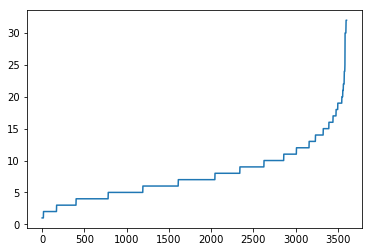

In [42]:
plt.plot(range(len(ll)), sorted(ll))
plt.show()

In [27]:
maxSentLen = 15

In [28]:
weD = 300
wvD = weD

In [29]:
def train(data, label):
    clf=LinearSVC(multi_class='crammer_singer',random_state=0)
    
    preds = model_selection.cross_val_predict(clf, data, label, cv=10)
    accScore = metrics.accuracy_score(label,preds)
    labels = [-1, 0, 1]
    precision = metrics.precision_score(label,preds,average=None,labels=labels)
    recall = metrics.recall_score(label,preds,average=None,labels=labels)
    f1Score = metrics.f1_score(label,preds,average=None,labels=labels)
    print("\nOverall Acurracy - SVM: ",accScore,"\n")
    for i in range(len(labels)):
        print("Precision of %s class: %f" %(labels[i],precision[i]))
        print("Recall of %s class: %f" %(labels[i],recall[i]))
        print("F1-Score of %s class: %f" %(labels[i],f1Score[i]),"\n")

In [30]:
X1 = []
y = []
yForSk = []
flag = "input"

In [31]:
for data in dataset:
    data1 = []
    meanAspVec = None
    
    #if more than one word in aspect term, take mean
    mean = np.zeros((weD, 1))
    for w in data[2]:
        twv = None
        try:
            if w in missingVectors:
                twv = missingVectors[w]
            else:
                twv = word2vec[w].reshape(weD, 1)
        except KeyError:
            twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
            missingVectors[w] = twv
        mean += twv
    meanAspVec = mean/len(data[2])
    
    E = []
    
#     for wv in data1:
#         E.append(np.dot(wv.T, meanAspVec)/(np.linalg.norm(wv)) * np.linalg.norm(meanAspVec))
    
#     E = np.array(E).reshape(300, 1)
#     A = np.exp(E) / np.sum(np.exp(E))

    for w in data[1]:
        twv = None
        try:
            if w in missingVectors:
                twv = missingVectors[w]
            else:
                twv = word2vec[w].reshape(weD, 1)
        except KeyError:
            twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
            missingVectors[w] = twv
        E.append(np.dot(twv.T, meanAspVec) / (np.linalg.norm(twv) * np.linalg.norm(meanAspVec)))

    A = np.exp(E) / np.sum(np.exp(E)) # softmax

    for i, w in enumerate(data[1]):
        twv = None
        if w in missingVectors:
            twv = missingVectors[w]
        else:
            twv = word2vec[w].reshape(weD, 1)
        if flag == "attention":
            data1.append(A[i] * twv)
        elif flag == "input":
            data1.append(twv)

#     for w in data[1]:
#         twv = None
#         try:
#             if w in missingVectors:
#                 twv = missingVectors[w]
#             else:
#                 twv = word2vec[w].reshape(300, 1)
#         except KeyError:
#             twv = np.random.normal(size=(300, 1))/math.sqrt(301)
#             missingVectors[w] = twv
            
#         data1.append(np.vstack((twv, meanAspVec)))
    
    if len(data1) < maxSentLen:
        j = len(data1) + 1
        while j <= maxSentLen:
            #data1.append(np.vstack((word2vec['#'].reshape(300, 1), meanAspVec)))
            #data1.append(np.vstack((np.zeros((300, 1)), meanAspVec)))
            data1.append(np.zeros((wvD, 1)))
            j += 1
    
    if len(data1) > maxSentLen:
        del data1[maxSentLen:]
    
    X1.append(np.array([np.mean(data1, axis=0)]).reshape(300,))
    yForSk.append(data[-1])
    if data[-1] == '-1':
        y.append(np.array([[0.0, 0.0, 1.0]]))
    elif data[-1] == '0':
        y.append(np.array([[0.0, 1.0, 0.0]]))
    elif data[-1] == '1':
        y.append(np.array([[1.0, 0.0, 0.0]]))

X1 = np.array(X1)
y = np.array(y)

In [32]:
X1.shape

(3602, 300)

In [33]:
y.shape

(3602, 1, 3)

In [34]:
np.shape(yForSk)

(3602,)

In [51]:
kf = StratifiedKFold(n_splits=10, shuffle=True)

In [35]:
train(X1, yForSk)


Overall Acurracy - SVM:  0.6785119378123264 

Precision of -1 class: 0.582665
Recall of -1 class: 0.450932
F1-Score of -1 class: 0.508403 

Precision of 0 class: 0.477778
Recall of 0 class: 0.135861
F1-Score of 0 class: 0.211562 

Precision of 1 class: 0.712755
Recall of 1 class: 0.921904
F1-Score of 1 class: 0.803949 



C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


In [58]:
# accuracies = []
# precisions = []
# recalls = []
# f1s = []

# for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
#     print("Fold -", index)
#     xtrain, xtest = X1[train_ind], X1[test_ind]
#     ytrain, ytest = y[train_ind], y[test_ind]
    
#     model = train(xtrain, ytrain)
    
#     predictions = model.predict(xtest)
    
#     y_pred = tf.argmax(predictions, dimension=1)
#     y_test = tf.argmax(ytest.reshape(len(ytest), 3), dimension=1)
    
#     print("Labels=", np.unique(y_test, return_counts=True))
#     print("Predictions=", np.unique(y_pred, return_counts=True))
    
#     cm = confusion_matrix(y_test, y_pred)
#     numer = np.diag(cm)
#     numer = numer.astype(np.float64)
#     deno = np.sum(cm, axis = 1, dtype=np.float64)
#     recall = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
#     deno = np.sum(cm, axis = 0, dtype=np.float64)
#     precision = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
#     #loss, acc = model.evaluate(xtest, ytest)
#     nnum = (precision*recall)
#     ddeno = (precision+recall)
#     f1 = 2*np.divide(nnum, ddeno, out=np.zeros_like(nnum), where=ddeno!=0)
#     acc = np.sum(numer)/np.sum(deno)
    
#     accuracies.append(acc)
#     precisions.append(precision)
#     recalls.append(recall)
#     f1s.append(f1)
#     print("accuracy=", acc, "precision=", precision, "recall=", recall, "F1 Score=", f1)


Fold - 0
Epoch 1/5
102/102 [==============================] - 9s 83ms/step - loss: 10.2660 - acc: 0.5958
Epoch 2/5
102/102 [==============================] - 8s 78ms/step - loss: 10.1070 - acc: 0.5983
Epoch 3/5
102/102 [==============================] - 8s 79ms/step - loss: 10.0637 - acc: 0.5983
Epoch 4/5
102/102 [==============================] - 10s 102ms/step - loss: 10.0308 - acc: 0.5983
Epoch 5/5
102/102 [==============================] - 9s 87ms/step - loss: 10.0021 - acc: 0.5983
Labels= (array([0, 1, 2], dtype=int64), array([217,  64,  81], dtype=int64))
Predictions= (array([0], dtype=int64), array([362], dtype=int64))
accuracy= 0.5994475138121547 precision= [0.59944751 0.         0.        ] recall= [1. 0. 0.] F1 Score= [0.74956822 0.         0.        ]
Fold - 1
Epoch 1/5
102/102 [==============================] - 8s 82ms/step - loss: 10.2972 - acc: 0.5965
Epoch 2/5
102/102 [==============================] - 8s 80ms/step - loss: 10.1187 - acc: 0.5983
Epoch 3/5
102/102 [=======

In [59]:
print("Average Scores:")
print("Avg. accuracy=", np.sum(accuracies)/len(accuracies))
print("Avg. precision=", np.sum(precisions, axis=0)/len(precisions))
print("Avg. recall=", np.sum(recalls, axis=0)/len(recalls))
print("Avg. f1=", np.sum(f1s, axis=0)/len(f1s))

Average Scores:
Avg. accuracy= 0.6007807120638463
Avg. precision= [0.60078071 0.         0.        ]
Avg. recall= [1. 0. 0.]
Avg. f1= [0.75060915 0.         0.        ]


In [269]:
cm

array([[120,   0,  78],
       [ 59,   0,  33],
       [ 83,   0,  91]])

In [234]:
pred = tf.one_hot(tf.argmax(predictions, dimension=1), depth=3)

In [242]:
pred.shape

TensorShape([Dimension(579), Dimension(3)])

In [37]:
#word2vec['#']#.reshape(300, 1) #numpy array
#print(word2vec.similarity('computer', 'laptop'))
#np.zeros(300).shape
#word2vec.distances(word2vec['computer'], other_words=["laptop"])
word2vec["###GB"]

array([-1.48437500e-01, -2.67333984e-02,  1.18652344e-01,  7.32421875e-03,
        1.42578125e-01,  8.69140625e-02, -1.10351562e-01,  1.30859375e-01,
        6.52343750e-01,  3.20312500e-01, -3.71093750e-01,  3.98437500e-01,
       -1.03515625e-01, -1.46484375e-01,  2.49023438e-01,  5.31250000e-01,
       -1.26953125e-02,  6.83593750e-03, -1.34277344e-02, -5.50781250e-01,
        3.93066406e-02, -1.61132812e-01, -1.97265625e-01, -3.46679688e-02,
        1.78710938e-01,  4.85839844e-02, -1.96289062e-01,  4.76562500e-01,
       -7.37304688e-02, -4.35546875e-01,  2.77099609e-02,  3.86718750e-01,
       -1.40625000e-01,  2.42187500e-01, -3.12500000e-01, -3.43750000e-01,
        4.88281250e-01, -2.53906250e-01, -9.08203125e-02,  2.19726562e-01,
        1.73828125e-01, -1.50390625e-01,  9.27734375e-02, -2.34375000e-02,
        2.51953125e-01, -9.03320312e-02, -9.91210938e-02, -1.99218750e-01,
        2.83203125e-01, -2.73437500e-01,  1.02539062e-01, -2.08984375e-01,
        9.70458984e-03,  